In [1]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import matplotlib as mpl
import os
import numpy as np
import seaborn as sns
import scipy
import pandas as pd
from tqdm import tqdm
import joblib

import preprocess as pp

In [2]:
class ProgressParallel(joblib.Parallel):
    def __call__(self, *args, **kwargs):
        with tqdm() as self._pbar:
            return joblib.Parallel.__call__(self, *args, **kwargs)

    def print_progress(self):
        self._pbar.total = self.n_dispatched_tasks
        self._pbar.n = self.n_completed_tasks
        self._pbar.refresh()

## TODO:

1. ~~outlier detection -- z score?~~
2. ~~better signal extraction~~
3. ~~superpixel segmentation~~
4. superpixel segmentation with stricter adherence to patch squareness/regularity
5. convert results array back to superpixels
6. optimize preprocess?

In [3]:
from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('font',**{'family':'serif','serif':['Times New Roman']})
# rc('text', usetex=True)

In [4]:
# test_video = 'data/marker_raw_480x480_30fps.mp4'
test_video = 'data/marker_raw.mp4'
if not os.path.isfile(test_video): raise Exception('invalid video path')

In [6]:
# preprocess
stabilized_array = pp.preprocess(
    test_video,
    output='array',
    smoothing_window=5,
    crop=True,
    crop_params={'new_width':540, 'new_height':540}
)
print(stabilized_array.shape)

cropping video {'new_width': 540, 'new_height': 540}
original video dimensions: width:1080, height:1080
new cropped video dimensions: width:1080, height:1080
final video dimensions: width:540, height:540


100%|██████████| 1415/1415 [00:05<00:00, 243.84it/s]


stabilizing output


100%|██████████| 1415/1415 [00:24<00:00, 56.88it/s]


smoothing output
(1415, 540, 540, 3)


In [26]:
# print possible even region sizes
side_dim = stabilized_array.shape[1]
even_region_sizes = [(i, side_dim//i) for i in range(1, int(np.sqrt(side_dim))+1) if side_dim % i == 0]
print(even_region_sizes)

[(1, 540), (2, 270), (3, 180), (4, 135), (5, 108), (6, 90), (9, 60), (10, 54), (12, 45), (15, 36), (18, 30), (20, 27)]


In [25]:
PARALLEL_NJOBS = 12

REGION_SIZE = 36
REGION_DIMS = stabilized_array.shape[1] // REGION_SIZE
NUM_REGIONS = REGION_DIMS ** 2

print(f'PARALLEL_NJOBS: {PARALLEL_NJOBS}')
print(f'REGION_SIZE: {REGION_SIZE}')
print(f'REGION_DIMS: {REGION_DIMS}')
print(f'NUM_REGIONS: {NUM_REGIONS}')

PARALLEL_NJOBS: 12
REGION_SIZE: 36
REGION_DIMS: 15
NUM_REGIONS: 225


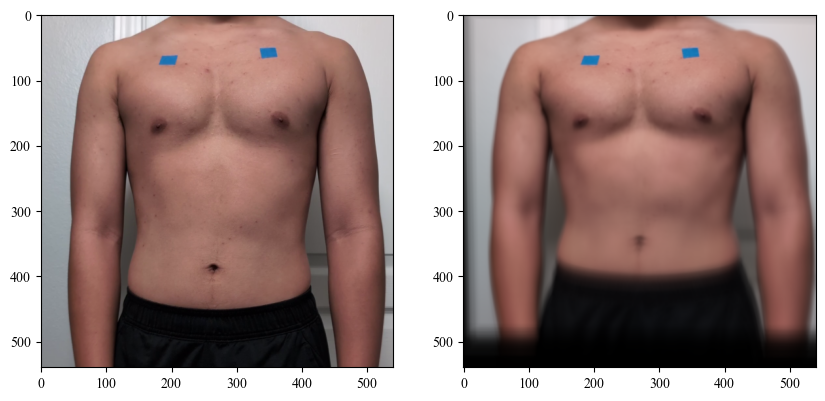

In [21]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv2.cvtColor(stabilized_array[0], cv2.COLOR_BGR2RGB))
ax[1].imshow(pp.smear(stabilized_array))

In [27]:
lsc_arr = pp.smear(stabilized_array)

In [28]:
lsc = cv2.ximgproc.createSuperpixelLSC(lsc_arr, 
                                       region_size=REGION_SIZE,
                                       ratio=0.075)
lsc.iterate(20)
lsc_mask = lsc.getLabels()
num_chunks = lsc.getNumberOfSuperpixels()

225 15


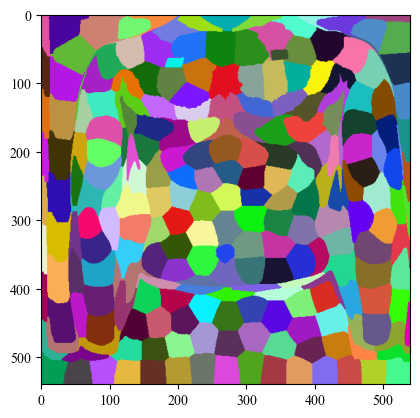

In [29]:
import random
colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(num_chunks)]
lsc_mask_rgb = np.zeros_like(lsc_arr)
for i in range(num_chunks):
    lsc_mask_rgb[lsc_mask == i] = colors[i]

side_dim = int(np.sqrt(num_chunks))
print(num_chunks, side_dim)
plt.figure()
plt.imshow(lsc_mask_rgb)
plt.show()

In [30]:
def mask_avg_image(mask, image):
    avg_image = np.zeros_like(image)
    for i in range(num_chunks):
        avg_image[mask == i] = np.mean(image[mask == i], axis=0)
    return avg_image

In [31]:
def mask_chunk_avg_image(mask, image):
    return np.array([np.mean(image[mask == i], axis=0) for i in range(num_chunks)])

In [32]:
mask_results = mask_avg_image(lsc_mask, stabilized_array[0])
r, g, b = stabilized_array[0][np.newaxis].transpose(3, 0, 1, 2)
blocking_results = np.dstack([pp.resize_func(np.mean, a, REGION_SIZE)[0] for a in (r, g, b)]).astype(np.uint8)
blocking_results = cv2.cvtColor(blocking_results, cv2.COLOR_BGR2RGB)

In [34]:
# takes a long time
run_lsc_extraction = True

In [35]:
def lsc_extraction_parallel(ndarray_vid, lsc_mask, n_jobs, chunk=True):
    func = mask_chunk_avg_image if chunk else mask_avg_image
    with joblib.parallel_config(backend='threading', n_jobs=n_jobs):
        results = ProgressParallel()(
                joblib.delayed(func)(lsc_mask, frame) for frame in ndarray_vid)
    
    return np.stack(results, axis=0)


In [36]:
if run_lsc_extraction:
    lsc_array = lsc_extraction_parallel(stabilized_array, lsc_mask, PARALLEL_NJOBS, chunk=False)
    np.save('data/superpixel_lsc.npy', lsc_array)
    pp.ndarray_to_vid(lsc_array, 'data/superpixel_lsc.mp4', 30)
else:
    lsc_array = np.load('data/superpixel_lsc.npy')

100%|██████████| 1415/1415 [01:35<00:00, 14.83it/s]


In [37]:
pp.video_playback_fromframes(lsc_array, fps=30)

In [38]:
if run_lsc_extraction:
    lsc_mean_array = lsc_extraction_parallel(stabilized_array, lsc_mask, PARALLEL_NJOBS, chunk=True)
    lsc_mean_array_4d = lsc_mean_array[:, :, np.newaxis, :].reshape(-1, side_dim, side_dim, 3).astype(np.uint8)
    lsc_mean_array_4d = np.rot90(lsc_mean_array_4d, k=-1, axes=(1, 2))
    np.save('data/superpixel_lsc_chunks.npy', lsc_mean_array_4d)
else:
    lsc_mean_array_4d = np.load('data/superpixel_lsc_chunks.npy')
print(lsc_mean_array_4d.shape)

100%|██████████| 1415/1415 [00:59<00:00, 23.72it/s]


(1415, 15, 15, 3)


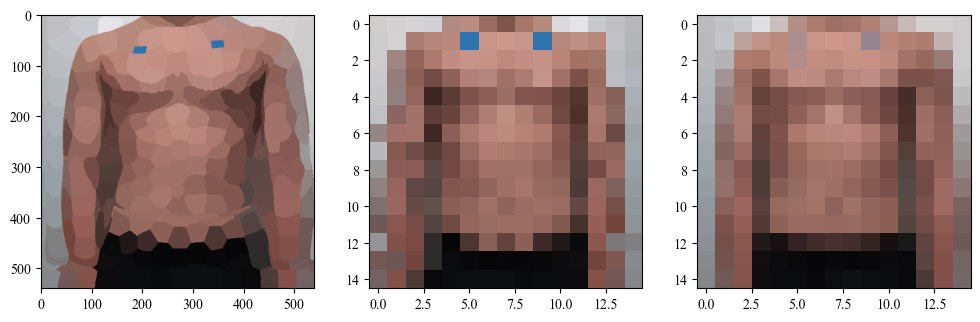

In [39]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax[0].imshow(cv2.cvtColor(mask_results, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(lsc_mean_array_4d[0], cv2.COLOR_BGR2RGB))
ax[2].imshow(blocking_results)
plt.savefig('images/superpixel_lsc_results.png', bbox_inches='tight')


In [40]:
# test_array = stabilized_array
test_array = lsc_mean_array_4d
cv_channels = {'b': 0, 'g': 1, 'r': 2}
test_array_green = test_array[:, :, :, cv_channels['g']]
test_array_red = test_array[:, :, :, cv_channels['r']]
test_array_blue = test_array[:, :, :, cv_channels['b']]
print(test_array_green.shape)

(1415, 15, 15)


(225, 1415)


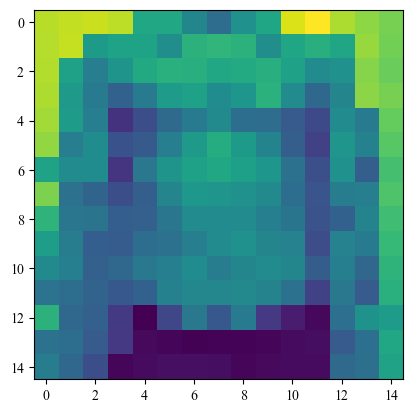

In [41]:
block_size = 1

n_frames = test_array_green.shape[0]
green_signals = pp.resize_func(np.mean, test_array_green, block_size).reshape(n_frames, -1).swapaxes(0, 1)
red_signals = pp.resize_func(np.mean, test_array_red, block_size).reshape(n_frames, -1).swapaxes(0, 1)
blue_signals = pp.resize_func(np.mean, test_array_blue, block_size).reshape(n_frames, -1).swapaxes(0, 1)
print(green_signals.shape)

plt.figure()
plt.imshow(pp.resize_func(np.mean, test_array_green, block_size)[0], cmap='viridis')
plt.show()

In [57]:
def chrom(r, g, b, fps):

    rgb_mean = (r + g + b) / 3
    Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean

    Xs = 3*Rn - 2*Gn
    Ys = 1.5*Rn + Gn - 1.5*Bn

    low_freq = 40/60
    high_freq = 240/60

    iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')

    Xf = scipy.signal.filtfilt(iirb, iira, Xs)
    Yf = scipy.signal.filtfilt(iirb, iira, Ys)

    alpha = np.std(Xf) / np.std(Yf)
    S = Xf - alpha*Yf

    return S

In [58]:
def pos(r, g, b, fps):
    # TODO: datatype mismatch?
    H = np.zeros_like(r)
    l = np.ceil((32 / 20) * fps).astype(int)
    rgb = np.stack([r, g, b], axis=-1)

    for n in range(rgb.shape[0]):
        m = n - l
        if m >= 0:
            cn = np.mat(rgb[m:n] / np.mean(rgb[m:n], axis=0)).H
            S = np.array([[0, 1, -1], [-2, 1, 1]]) @ cn
            h = np.ravel( S[0, :] + (np.std(S[0, :]) / np.std(S[1, :])) * S[1, :] )
            H[m:n] += h - np.mean(h)
    
    low_freq = 40/60
    high_freq = 240/60

    iirb, iira = scipy.signal.butter(3, ((2*low_freq)/fps, (2*high_freq)/fps), 'bandpass')
    S = scipy.signal.filtfilt(iirb, iira, H)

    return S


In [59]:
def show_sig(sigfunc, r, g, b, fps=30, window=None):
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    t = np.arange(len(r)) / fps
    if window: ax1.set_xlim(window)
    ax1.plot(t, r, color='red')
    ax1.plot(t, g, color='green')
    ax1.plot(t, b, color='blue')
    ax2.plot(t, sigfunc(r, g, b, fps), color='black')
    plt.show()

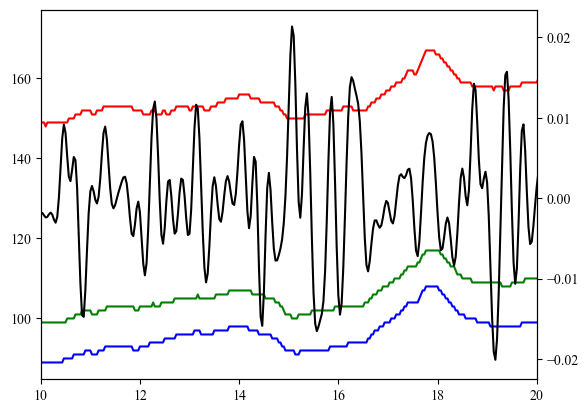

In [60]:
idx = len(red_signals) // 2
window = (10, 20)
show_sig(chrom, red_signals[idx], green_signals[idx], blue_signals[idx], 30, window)

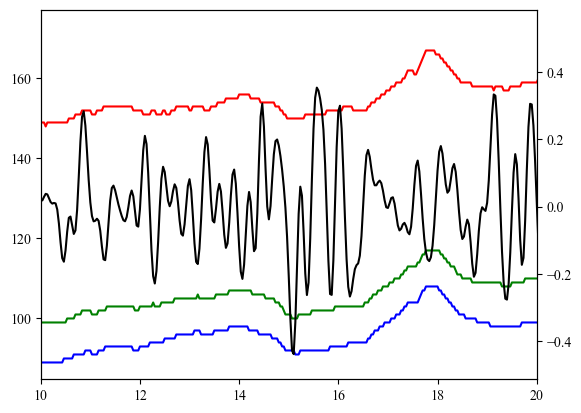

In [61]:
idx = len(red_signals) // 2
window = (10, 20)
show_sig(pos, red_signals[idx], green_signals[idx], blue_signals[idx], 30, window)

In [62]:
def score_fft(sigfft, fps, k=1):
    
    topk = np.argsort(sigfft)[-k:][::-1]

    return sigfft[topk], topk*60/fps

In [63]:
def fit_chrom(r, g, b, fps=30):
    return score_fft(np.abs(np.fft.rfft(chrom(r, g, b, fps))), fps, 1)

In [64]:
def fit_pos(r, g, b, fps=30):
    return score_fft(np.abs(np.fft.rfft(pos(r, g, b, fps))), fps, 1)

In [67]:
def fit(reds, greens, blues, fit_func, fps=30, n_jobs=PARALLEL_NJOBS):
    with joblib.parallel_config(backend='threading', n_jobs=n_jobs):
        results = ProgressParallel()(
                joblib.delayed(fit_func)(r, g, b, fps) for r, g, b in zip(reds, greens, blues))

    bpm, bpm_vals = [], []
    for e in results:
        (topk_val,), (topk_bpm,) = e
        bpm.append(topk_bpm)
        bpm_vals.append(topk_val)
    bpm = np.array(bpm)
    bpm[bpm > 200] = 0

    return bpm

In [68]:
def score(bpms, resolution=480):
    bpm_2d = bpms.reshape(resolution//block_size, -1)
    print(f'generated results of shape {bpm_2d.shape}')
    # bpm_mean = np.mean(bpm_2d[bpm_2d > 0])
    hist, bins = np.histogram(bpms, bins=30)
    bpm_mean = np.mean(bins[np.argmax(hist[1:])])
    bpm_std = np.std(bpm_2d[bpm_2d > 0])
    bpm_zscore = (bpm_2d - bpm_mean)/bpm_std
    print(f'bpm mean: {bpm_mean}, bpm std: {bpm_std}')

    fig, ax = plt.subplots(1, 3, figsize=(16, 4))

    ax[0].imshow(test_array[0][:,:,[2,1,0]], 
                 extent=[0, resolution, resolution, 0])
    bound = 1
    im = ax[1].imshow(bpm_zscore, 
                      cmap='RdBu', 
                      alpha=1, 
                      extent=[0, resolution, 0, resolution], 
                      aspect='auto', 
                      vmin=-bound, vmax=bound)
    fig.colorbar(im, ax=ax[1])
    ax[1].set_ylim(resolution, 0)
    ax[1].set(aspect='equal')

    sns.histplot(bpms, bins=30, kde=True, ax=ax[2])


0it [00:00, ?it/s]C:\Users\Tienda\AppData\Local\Temp\ipykernel_3716\3744578747.py:4: RuntimeWarning: invalid value encountered in divide
  Rn, Gn, Bn = r/rgb_mean, g/rgb_mean, b/rgb_mean
100%|██████████| 225/225 [00:00<00:00, 288.86it/s]
c:\Users\Tienda\miniconda3\envs\chest-rppg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


generated results of shape (15, 15)
bpm mean: 84.93333333333334, bpm std: 30.1212348435206


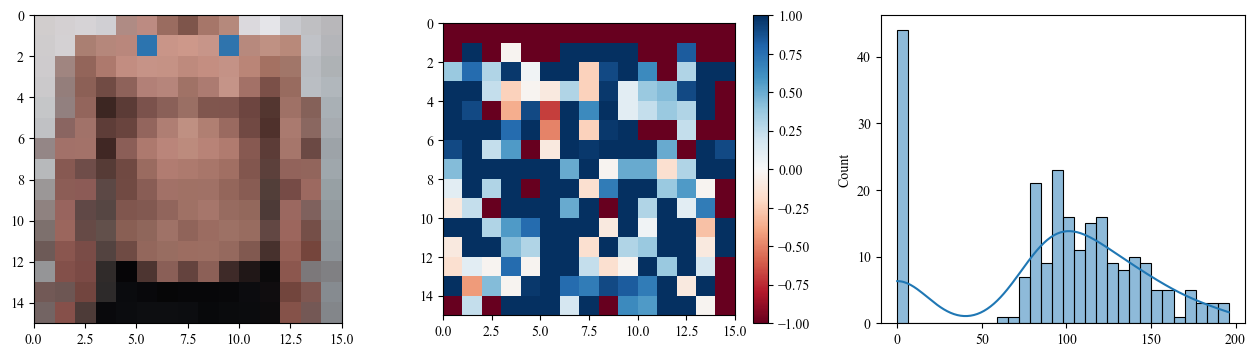

In [69]:
bpm_chrom = fit(red_signals, green_signals, blue_signals, fit_chrom)
score(bpm_chrom, resolution=side_dim)

0it [00:00, ?it/s]C:\Users\Tienda\AppData\Local\Temp\ipykernel_3716\1658260419.py:12: RuntimeWarning: invalid value encountered in scalar divide
  h = np.ravel( S[0, :] + (np.std(S[0, :]) / np.std(S[1, :])) * S[1, :] )
C:\Users\Tienda\AppData\Local\Temp\ipykernel_3716\1658260419.py:10: RuntimeWarning: invalid value encountered in divide
  cn = np.mat(rgb[m:n] / np.mean(rgb[m:n], axis=0)).H
100%|██████████| 225/225 [00:33<00:00,  6.72it/s]
c:\Users\Tienda\miniconda3\envs\chest-rppg\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


generated results of shape (15, 15)
bpm mean: 104.53333333333333, bpm std: 31.459443726087855


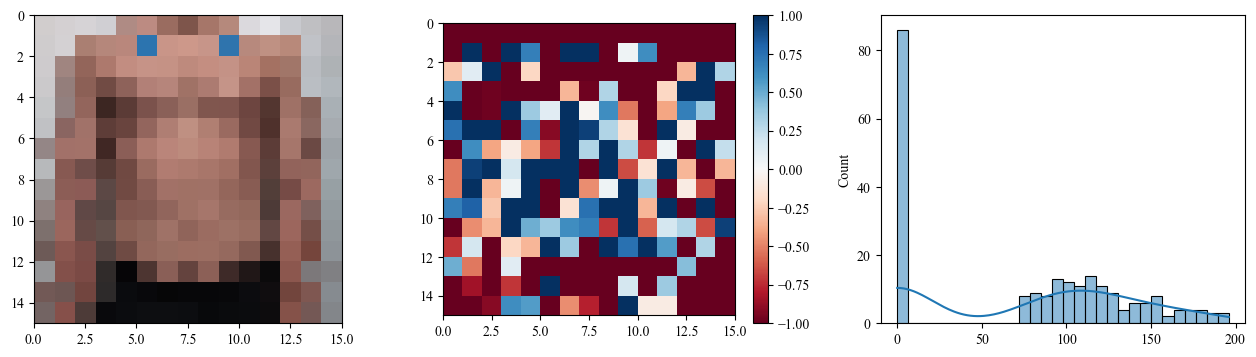

In [70]:
bpm_pos = fit(red_signals, green_signals, blue_signals, fit_pos)
score(bpm_pos, resolution=side_dim)